## Target Encoding

In [61]:
from category_encoders import TargetEncoder
from sklearn.compose import make_column_selector
import seaborn as sns
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import seaborn as sns

### シングルクラス（生存・非生存）

In [5]:

df = sns.load_dataset('titanic')
df.dropna(inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 1 to 889
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     182 non-null    int64   
 1   pclass       182 non-null    int64   
 2   sex          182 non-null    object  
 3   age          182 non-null    float64 
 4   sibsp        182 non-null    int64   
 5   parch        182 non-null    int64   
 6   fare         182 non-null    float64 
 7   embarked     182 non-null    object  
 8   class        182 non-null    category
 9   who          182 non-null    object  
 10  adult_male   182 non-null    bool    
 11  deck         182 non-null    category
 12  embark_town  182 non-null    object  
 13  alive        182 non-null    object  
 14  alone        182 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 18.2+ KB


In [9]:
# 以下では学習・テスト用分けていないので一律で
# また、adult_maleはbooleanなのでカテゴリカル変数の対象外
encoder = TargetEncoder()
encoder.fit(df,df['survived'])
encoder.transform(df)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,0.931533,38.0,1,0,71.2833,0.737773,0.675159,0.950662,False,0.592011,0.737773,0.999989,False
3,1,1,0.931533,35.0,1,0,53.1000,0.643481,0.675159,0.950662,False,0.592011,0.643481,0.999989,False
6,0,1,0.436317,54.0,0,0,51.8625,0.643481,0.675159,0.391155,True,0.717867,0.643481,0.013409,True
10,1,3,0.931533,4.0,1,1,16.7000,0.643481,0.628538,0.732342,False,0.646289,0.643481,0.999989,False
11,1,1,0.931533,58.0,0,0,26.5500,0.643481,0.675159,0.950662,False,0.592011,0.643481,0.999989,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,0.931533,47.0,1,1,52.5542,0.643481,0.675159,0.950662,False,0.725425,0.643481,0.999989,False
872,0,1,0.436317,33.0,0,0,5.0000,0.643481,0.675159,0.391155,True,0.737957,0.643481,0.013409,True
879,1,1,0.931533,56.0,0,1,83.1583,0.737773,0.675159,0.950662,False,0.592011,0.737773,0.999989,False
887,1,1,0.931533,19.0,0,0,30.0000,0.643481,0.675159,0.950662,False,0.737957,0.643481,0.999989,True


In [11]:
df['adult_male'] = df['adult_male'].astype('object')
encoder.fit(df,df['survived'])
encoder.transform(df)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,0.931533,38.0,1,0,71.2833,0.737773,0.675159,0.950662,0.936698,0.592011,0.737773,0.999989,False
3,1,1,0.931533,35.0,1,0,53.1000,0.643481,0.675159,0.950662,0.936698,0.592011,0.643481,0.999989,False
6,0,1,0.436317,54.0,0,0,51.8625,0.643481,0.675159,0.391155,0.391155,0.717867,0.643481,0.013409,True
10,1,3,0.931533,4.0,1,1,16.7000,0.643481,0.628538,0.732342,0.936698,0.646289,0.643481,0.999989,False
11,1,1,0.931533,58.0,0,0,26.5500,0.643481,0.675159,0.950662,0.936698,0.592011,0.643481,0.999989,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,1,0.931533,47.0,1,1,52.5542,0.643481,0.675159,0.950662,0.936698,0.725425,0.643481,0.999989,False
872,0,1,0.436317,33.0,0,0,5.0000,0.643481,0.675159,0.391155,0.391155,0.737957,0.643481,0.013409,True
879,1,1,0.931533,56.0,0,1,83.1583,0.737773,0.675159,0.950662,0.936698,0.592011,0.737773,0.999989,False
887,1,1,0.931533,19.0,0,0,30.0000,0.643481,0.675159,0.950662,0.936698,0.737957,0.643481,0.999989,True


### マルチクラス（種類）

In [30]:
df = pd.read_csv('penguins_size.csv')
df.loc[df[df['sex']=='.'].index[0], 'sex'] = np.nan

In [31]:
targets = df['species'].unique()

In [40]:
# target_encoding
# = カテゴリカル変数の各カテゴリを目的変数の平均値（厳密にはスムージングもされているらしいが）

# 以下をカテゴリカル変数ごとに実施
# 実際に.fitの際はテストデータを含めない
for target in targets:
    target_y = (df['species'] == target)
    encoder = TargetEncoder()
    df['encoded_island_'+target] = encoder.fit_transform(df['island'], target_y)

In [39]:
df

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,encoded_island_Adelie,encoded_island_Chinstrap,encoded_island_Gentoo
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,0.978140,7.742061e-03,0.014118
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,0.978140,7.742061e-03,0.014118
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,0.978140,7.742061e-03,0.014118
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,0.978140,7.742061e-03,0.014118
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,0.978140,7.742061e-03,0.014118
...,...,...,...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN,0.261905,7.385705e-08,0.738095
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,0.261905,7.385705e-08,0.738095
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE,0.261905,7.385705e-08,0.738095
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,0.261905,7.385705e-08,0.738095


## target encodingと one-hot encodingの比較
- 5foldCV × 3 （モデルの汎化性能を見るため）
- 欠損値代入
    - カテゴリカル変数：最頻値
    - 数値：中央値
- 標準化
- target encodingとone-hot encodingで精度比較
- モデルはなんでもOK
- 評価指標はなんでもOK

In [51]:
df = sns.load_dataset('titanic')
df = df.drop('alive', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(4)
memory usage: 73.7+ KB


In [52]:
# adult_maleとaloneをカテゴリカル変数へ
df['adult_male'] = df['adult_male'].astype('object')
df['alone'] = df['alone'].astype('object')


In [82]:
target = 'survived'
X = df.drop(target, axis=1)
y = df[target]
results = {}
scores = {}

In [83]:

# CV
k = 5
n_repeates = 3
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeates, random_state = 0)

class GetDummies(BaseEstimator, TransformerMixin): #2つのクラスを継承
    
    def __init__(self):
        self.columns = None

    def fit(self, X, y = None):
        self.columns = pd.get_dummies(X).columns
        return self
    
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns = self.columns, fill_value = 0)


# 欠損値代入　→ カテゴリカル変数のEncoding →　標準化　→ モデル学習
    
num_pipeline = Pipeline([('imputer_num', SimpleImputer(strategy = 'median'))])

# カテゴリカル変数の処理
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent'))
])

# ColumnTransformerの定義
ct = ColumnTransformer([
    ('num_pipeline', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat_pipeline', cat_pipeline, make_column_selector(dtype_exclude=np.number))
])

ct.set_output(transform='pandas')

# target-encoding

pipeline_te = Pipeline(steps= [('ct', ct),
                            ('target_encoding', TargetEncoder()),
                            ('scaler', StandardScaler()),
                            ('model', LogisticRegression())
                           ]) 

score = cross_val_score(pipeline_te, X, y, cv = cv, scoring='accuracy')
scores['target_encoding'] = score
results['target_encoding'] = np.mean(score)
results  


# one-hot-encoding
# カラムのダミー変数化用のクラス
class GetDummies(BaseEstimator, TransformerMixin): #2つのクラスを継承
    
    def __init__(self):
        self.columns = None
    def fit(self, X, y = None):
        self.columns = pd.get_dummies(X).columns
        return self
    def transform(self, X):
        X_new = pd.get_dummies(X)
        return X_new.reindex(columns = self.columns, fill_value = 0)

pipeline_oh = Pipeline(steps= [('ct', ct),
                            ('onehot_encoding', GetDummies()),
                            ('scaler', StandardScaler()),
                            ('model', LogisticRegression())
                           ]) 

score = cross_val_score(pipeline_oh, X, y, cv = cv, scoring='accuracy')
scores['onehot'] = score
results['onehot'] = np.mean(score)
results


{'target_encoding': 0.8226769610612432, 'onehot': 0.8189421044922898}

In [84]:
scores

{'target_encoding': array([0.83240223, 0.78089888, 0.82022472, 0.84831461, 0.83146067,
        0.79888268, 0.79775281, 0.89325843, 0.79213483, 0.83707865,
        0.82122905, 0.86516854, 0.79213483, 0.81460674, 0.81460674]),
 'onehot': array([0.83240223, 0.7752809 , 0.81460674, 0.84831461, 0.83146067,
        0.7877095 , 0.81460674, 0.87078652, 0.80337079, 0.81460674,
        0.80446927, 0.86516854, 0.78651685, 0.80898876, 0.8258427 ])}

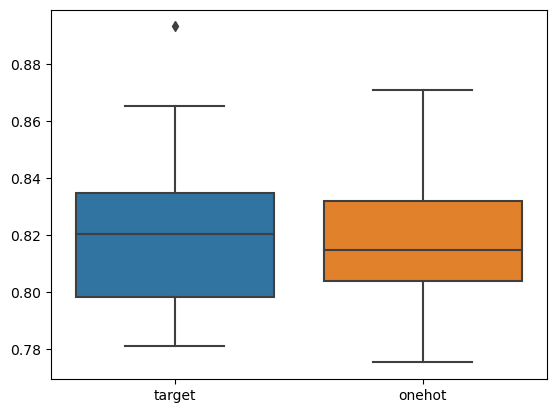

In [86]:
import matplotlib.pyplot as plt

sns.boxplot(data=[scores['target_encoding'], scores['onehot']])
plt.xticks([0,1],['target', 'onehot'])
plt.show()

In [88]:
# TEの方が優れてる　少し
results

{'target_encoding': 0.8226769610612432, 'onehot': 0.8189421044922898}

## 注意
- 標準化や欠損値代入と同じように、TargetEncodingもパイプラインに組み込んでCVの中で行うことが必須（target leakageを回避）

 - dfで一気にエンコーディングをかけて、そのデータに対して5FoldするのではNG
 - テストデータを含んだ形で学習データのエンコーディングした結果に目的変数が含まれる形になり過学習気味になる。
-  ここでいうテストデータは、train,testのテストではなく、KFoldなどCV時のvalidationデータ